In [1]:
! pip install --quiet "tabulate" "ipython[notebook]>=8.0.0, <8.12.0" "pytorch-lightning>=1.4, <2.0.0" "torchvision" "setuptools==67.4.0" "seaborn" "torch>=1.8.1, <1.14.0" "matplotlib" "torchmetrics>=0.7, <0.12" "lightning>=2.0.0rc0"


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC, MulticlassF1Score
from torchvision import transforms
from prep import CustomImageDataset
from prep_img import RandomTranslateCrop, CenterCrop

path_img = 'C:\\mimic-cxr-jpg\\train'
BATCH_SIZE = 64

In [3]:
train_label = "C:\\mimic-cxr-jpg\\train_set.csv"
val_label = "C:\\mimic-cxr-jpg\\val_set.csv"
test_label = "C:\\mimic-cxr-jpg\\test_set.csv"

train_set = CustomImageDataset(train_label,path_img,transform=CenterCrop(128))
val_set = CustomImageDataset(val_label,path_img,transform=CenterCrop(128))
test_set = CustomImageDataset(test_label,path_img,transform=CenterCrop(128))

In [4]:
class ConvNet(L.LightningModule):
     def __init__(self, input_shape, num_classes=15, learning_rate=3e-4):

         super().__init__()
         self.save_hyperparameters()
         self.learning_rate = learning_rate
         self.num_classes = num_classes

         self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
         self.conv1 = nn.Conv2d(1, 128, 3, 1)
         self.conv2 = nn.Conv2d(128, 128, 3, 1)
         self.conv3 = nn.Conv2d(128,256 , 3, 1)
         self.conv4 = nn.Conv2d(256, 256, 3, 1)

         self.pool1 = torch.nn.MaxPool2d(2)
         self.pool2 = torch.nn.MaxPool2d(2)

         n_sizes = self._get_output_shape(input_shape)

         self.fc1 = nn.Linear(n_sizes, 512)
         self.fc2 = nn.Linear(512, 128)
         self.fc3 = nn.Linear(128, num_classes)

         self.train_accuracy = MulticlassAccuracy(num_classes=num_classes)
         self.val_accuracy = MulticlassAccuracy(num_classes=num_classes)
         self.test_accuracy = MulticlassAccuracy(num_classes=num_classes)

         self.train_auroc = MulticlassAUROC(num_classes=num_classes)
         self.val_auroc = MulticlassAUROC(num_classes=num_classes)
         self.test_auroc = MulticlassAUROC(num_classes=num_classes)

         self.train_f1 = MulticlassF1Score(num_classes=num_classes)
         self.val_f1 = MulticlassF1Score(num_classes=num_classes)
         self.test_f1 = MulticlassF1Score(num_classes=num_classes)

     def _get_output_shape(self, shape):
        '''returns the size of the output tensor from the conv layers'''

        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._feature_extractor(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

     def _feature_extractor(self, x):
        '''extract features from the conv blocks'''
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x

     def forward(self, x):
       '''produce final model output'''
       x = self._feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       return x

     def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds,y)

        preds = torch.softmax(logits,dim=1)
        self.train_auroc.update(preds,y)

        preds = torch.argmax(logits, dim=1)
        self.train_f1.update(preds,y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True)
        self.log("train_roc", self.train_auroc, prog_bar=True)
        self.log("train_f1", self.train_f1, prog_bar=True)
        return loss

     def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds,y)

        preds = torch.softmax(logits,dim=1)
        self.val_auroc.update(preds,y)

        preds = torch.argmax(logits, dim=1)
        self.val_f1.update(preds,y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        self.log("val_roc", self.val_auroc, prog_bar=True)
        self.log("val_f1", self.val_f1, prog_bar=True)

     def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        preds = torch.softmax(logits,dim=1)
        self.test_auroc.update(preds, y)

        preds = torch.argmax(logits, dim=1)
        self.test_f1.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        self.log("test_roc", self.test_auroc, prog_bar=True)
        self.log("test_f1", self.test_f1, prog_bar=True)

     def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

     def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.set_train, self.set_val = train_set,val_set

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.set_test = test_set

     def train_dataloader(self):
        return DataLoader(self.set_train, batch_size=BATCH_SIZE,num_workers=0)

     def val_dataloader(self):
       return DataLoader(self.set_val, batch_size=BATCH_SIZE,num_workers=0)

     def test_dataloader(self):
        return DataLoader(self.set_test, batch_size=BATCH_SIZE,num_workers=0)

In [5]:
model = ConvNet((1, 128, 128),5)
trainer = L.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=8,
    logger=CSVLogger(save_dir="logs/"),
)
#trainer.fit(model)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.test()

TypeError: `Trainer.test()` requires a `LightningModule` when it hasn't been passed in a previous run

,val_acc,val_roc,val_f1
epoch,,,
0,NaN,NaN,NaN
0,NaN,NaN,NaN
0,NaN,NaN,NaN
0,NaN,NaN,NaN
0,NaN,NaN,NaN


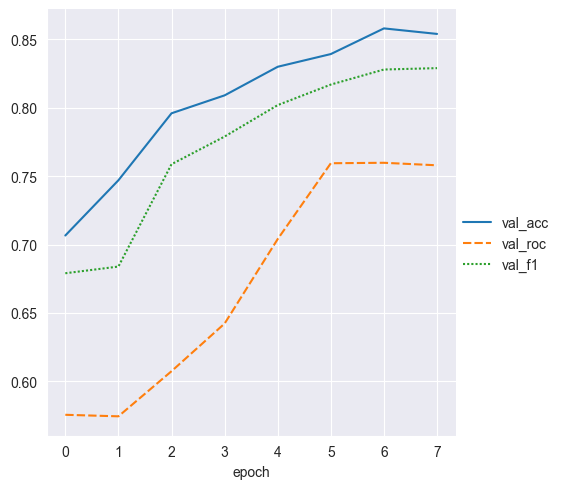

In [9]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics_cl.csv")
metrics = metrics.drop(["test_acc","test_roc","test_f1","test_loss"],axis=1)
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")